<a href="https://colab.research.google.com/github/amutharun/LangGraph/blob/main/LG_Supervisor_Agent_Websearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agents with Langgraph

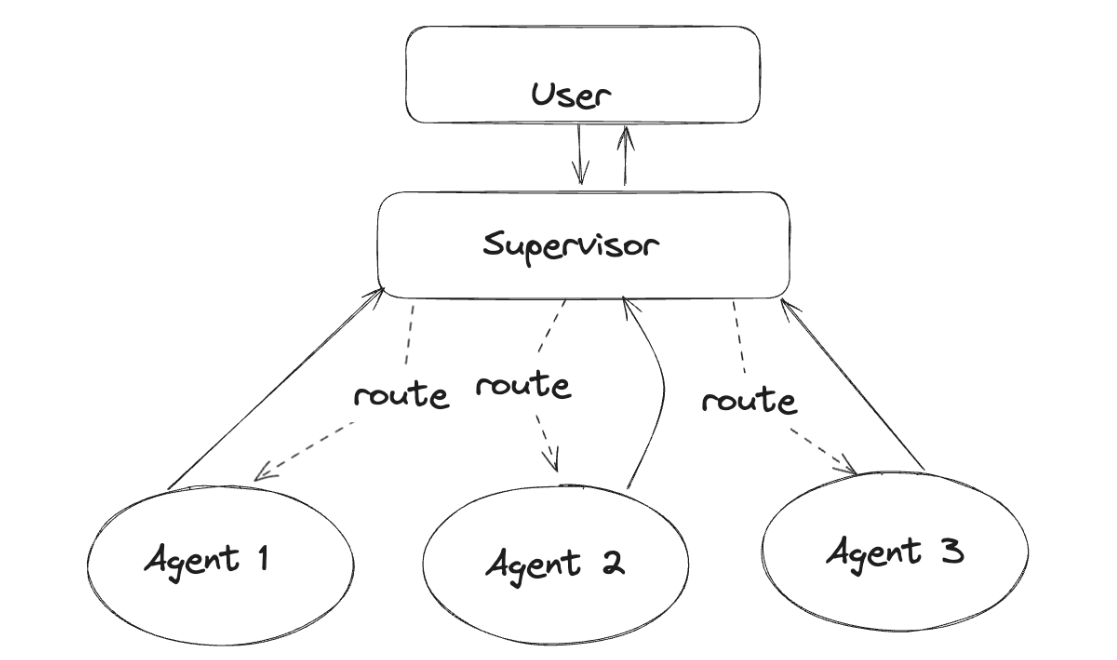

#### Import libraries

In [ ]:
!pip install -r /content/LangGraph_requirements.txt

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from bs4 import BeautifulSoup
from duckduckgo_search import DDGS
import functools, operator, requests, os, json
from langchain.tools import tool
from langgraph.graph import StateGraph, END
from langchain_core.messages import BaseMessage, HumanMessage
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
from langgraph_utils import get_web_retriever_tool, get_agent_node, get_supervisor_node, run_graph

#### Load environment variables

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()

True

#### Define LLM

#### OpenAI Style

In [ ]:
# from langchain.chat_models import ChatOpenAI
# from langchain.embeddings.openai import OpenAIEmbeddings

# OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
# llm  = ChatOpenAI()
# embeddings = OpenAIEmbeddings()

#### Azure Style

In [ ]:
# Azure Open AI way

from langchain.chat_models import AzureChatOpenAI
from langchain.embeddings.openai import OpenAIEmbeddings


EMBEDDING_DEPLOYMENT_NAME = os.getenv('EMBEDDING_DEPLOYMENT_NAME')
CHATGPT_16K_DEPLOYMENT_NAME = os.getenv('CHATGPT_16K_DEPLOYMENT_NAME')
CHATGPT_TURBO_DEPLOYMENT_NAME = os.getenv('CHATGPT_TURBO_DEPLOYMENT_NAME')
GPT4_DEPLOYMENT_NAME = os.getenv('GPT4_DEPLOYMENT_NAME')
GPT4_TURBO_DEPLOYMENT_NAME = os.getenv('GPT4_TURBO_DEPLOYMENT_NAME')

API_KEY = os.getenv('southindia_API_KEY')
API_BASE = os.getenv('southindia_API_BASE')
API_TYPE = os.getenv('API_TYPE')
API_VERSION = os.getenv('API_VERSION')

embeddings = OpenAIEmbeddings(deployment=EMBEDDING_DEPLOYMENT_NAME,
                              openai_api_key=API_KEY,
                              openai_api_base=API_BASE,
                              openai_api_version=API_VERSION,
                              openai_api_type=API_TYPE,
                              chunk_size=1)

llm = AzureChatOpenAI(
        openai_api_base=API_BASE,
        openai_api_version=API_VERSION,
        deployment_name=GPT4_TURBO_DEPLOYMENT_NAME,
        openai_api_key=API_KEY,
        openai_api_type=API_TYPE,
        temperature=0
    )

In [ ]:
llm.invoke("What is 2+2 ?")

AIMessage(content='2 + 2 equals 4.')

#### Define custom tools

In [ ]:
# Create a tool to search the internet using DuckDuckGo.
@tool("Web_Searcher", return_direct=False)
def internet_search(query: str) -> str:
    """Use this tool when you need to answer questions related to current events and latest happenings"""
    with DDGS() as ddgs:
        results = [r for r in ddgs.text(query, max_results=5)]
        return results if results else "No results found."

# Create a tool to processes content from a webpage
@tool("Insight_Researcher", return_direct=False)
def process_content(url: str) -> str:
    """Use this tool to extract the content from the html pages"""
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    return soup.get_text()

#### Create a tool list out of the tools defined above

In [ ]:
tools = [internet_search, process_content]

#### Create Agents as nodes

In [ ]:
# Dict of agent descriptions. format : "Agent Name" : "Prompt for the agent"
members = {
        "Web_Searcher": """You are a web searcher trained to retrieve the current events from the internet. Search the internet for information.
                                PLEASE NOTE THAT IF NO SPECIFIC YEAR MENTIONED IN THE QUESTION, ALWAYS LOOK FOR THE LATEST YEAR.""",

        "Insight_Researcher": """You are a Insight Researcher. Do step by step.
                                    Based on the provided content first identify the list of topics,
                                    then search internet for each topic one by one and finally detail out each topic one by one in a readable format with sub headings.
                                    Include the detailed response and sources in the end."""
          }


search_node_name = "Web_Searcher"
insight_node_name = "Insight_Researcher"


In [ ]:
# Defining Agent Nodes using the name, tools and the prompt
search_node = get_agent_node(llm, search_node_name, tools, system_prompt=members[search_node_name])
insight_node = get_agent_node(llm, insight_node_name, tools, system_prompt=members[insight_node_name])

#### Create Supervisor Node

In [ ]:
system_prompt = ("""As a supervisor, your role is to oversee a dialogue between these workers: {members}.
                    Based on the user's request determine which worker should take the next action. Each worker is responsible for
                    executing a specific task and reporting back their findings and progress. Once all tasks are complete,
                    Make the answers readable and Include sources in the end.
                    indicate with 'FINISH'.""")

# Create a supervisor node who will oversee the members which are passed to the
supervisor_node = get_supervisor_node(llm=llm, system_prompt=system_prompt, members=list(members.keys()))

Create the Graph

In [ ]:
# Define the Agent State, Edges and Graph
from langgraph_utils import AgentState

# Create an emppy graph to which nodes can be added
workflow = StateGraph(AgentState)

# add all the agents (in any order)
workflow.add_node("Web_Searcher", search_node)
workflow.add_node("Insight_Researcher", insight_node)
workflow.add_node("supervisor", supervisor_node)

# Define the entry point for the graph. Supervisor here is the one who decides what's the next best action
workflow.set_entry_point("supervisor")

# Based on the user questions the next action is routed by the supervisor to the members (agents)
conditional_map = {k: k for k in members} # Dict of agents with key and value as agent names
conditional_map["FINISH"] = END # End state is determined by the supervisor when the latest entry in the state of the graph is FINISH
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

# Define edges - relationship between agents
# edges are created between the supervisor and the agents
for member in members:
    workflow.add_edge(member, "supervisor") # Unidirectional edge between member to supervisor

graph = workflow.compile()

#### Run the graph

In [ ]:
question = """What is the recent happening between Elon Musk and Open AI?"""

run_graph(graph, question)

ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending name='Task-12' coro=<AsyncCurl._force_timeout() running at /usr/local/lib/python3.10/dist-packages/curl_cffi/aio.py:181> wait_for=<Future pending cb=[Task.__wakeup()]>>


The recent developments in the legal dispute between Elon Musk and OpenAI have been covered by various news outlets. Here are some of the latest updates:

1. CBS News reports that the relationship between Elon Musk and OpenAI has become increasingly acrimonious and public, with both parties lobbing allegations at each other. [Read more](https://www.cbsnews.com/news/elon-musk-openai-tesla-lawsuit-sam-altman/)

2. AP News highlights that Elon Musk is suing OpenAI and its CEO Sam Altman, accusing them of betraying ChatGPT maker's founding aims of benefiting humanity rather than pursuing profits. [Read more](https://apnews.com/article/openai-sam-altman-investigation-chatgpt-elon-musk-ff9f20b1e687064d9f7f43af5844148e)

3. CNBC provides access to the complaint filed by Elon Musk against Sam Altman and Greg Brockman of OpenAI, which includes allegations about the secrecy of OpenAI's GPT-4 AI model. [Read more](https://www.cnbc.com/2024/03/05/read-the-complaint-in-elon-musk-v-sam-altman-greg-brockman-openai.html)

4. Business Insider discusses how OpenAI's response, which included publishing emails from Elon Musk, could be a significant blow to Musk's legal case. [Read more](https://www.businessinsider.com/elon-musk-emails-hurt-changes-openai-lawsuit-experts-2024-3?op=1)

5. Yahoo News covers OpenAI's response to Elon Musk's lawsuit, where the organization released emails showing Musk's support for the creation of a for-profit entity. [Read more](https://news.yahoo.com/openai-hits-back-elon-musk-102536170.html)

6. Ars Technica reports on OpenAI's response to Elon Musk's lawsuit by clarifying its "open" nature and sharing archived emails from Musk. [Read more](https://arstechnica.com/information-technology/2024/03/openai-clarifies-the-meaning-of-open-in-its-name-responding-to-musk-lawsuit/)

7. TechCrunch mentions that OpenAI intends to dismiss all claims made by Elon Musk in the lawsuit and suggests that the company's response reveals new details about the dispute. [Read more](https://techcrunch.com/2024/03/05/openai-response-elon-musk-lawsuit/)

8. The Verge reports that OpenAI has responded to Elon Musk's lawsuit by saying that he at one point wanted "absolute control" of the company by merging it with Tesla. [Read more](https://www.theverge.com/2024/3/5/24091773/openai-response-elon-musk-breach-of-contract-lawsuit)

9. IGN covers OpenAI's refutation of Elon Musk's lawsuit and the publication of private emails between Musk and the company. [Read more](https://www.ign.com/articles/openai-refutes-elon-musks-lawsuit-publishes-private-emails)

10. The Washington Post discusses how OpenAI published old emails showing that Elon Musk lobbied to merge the AI lab with Tesla and use the car company as a 'cash cow' for OpenAI. [Read more](https://www.washingtonpost.com/business/2024/03/06/open-ai-musk-lawsuit-agi-profit-emails/)

These articles provide a comprehensive view of the ongoing legal battle and the arguments being made by both sides.

In [ ]:
question = """Why did Elon Musk file a case against Open AI?"""

response = run_graph(graph, question)

Elon Musk has filed a lawsuit against OpenAI and its CEO Sam Altman. The lawsuit alleges that OpenAI has diverged from its original nonprofit mission and is now operating with secrecy around its AI models, such as GPT-4, and partnering with companies like Microsoft. Musk's attorneys claim that this secrecy is a departure from the company's commitment to developing artificial intelligence for the benefit of all. The relationship between Musk and OpenAI has become acrimonious, with allegations being lobbed between the parties. OpenAI has responded to the lawsuit, suggesting there is a dispute over the direction and principles guiding OpenAI's operations.

For more detailed information, you can read the articles from various sources:
- [CNBC](https://www.cnbc.com/2024/03/05/read-the-complaint-in-elon-musk-v-sam-altman-greg-brockman-openai.html)
- [CBS News](https://www.cbsnews.com/news/elon-musk-openai-tesla-lawsuit-sam-altman/)
- [AP News](https://apnews.com/article/openai-sam-altman-investigation-chatgpt-elon-musk-ff9f20b1e687064d9f7f43af5844148e)
- [The New York Times](https://www.nytimes.com/2024/03/01/technology/elon-musk-openai-sam-altman-lawsuit.html)
- [CNN](https://www.cnn.com/2024/03/01/tech/elon-musk-lawsuit-openai-sam-altman/index.html)

In [ ]:
question = """What are the latest changes under IFRS with an effective date in 2024 ?"""

response = run_graph(graph, question)

### New IFRS Accounting Standards Effective After 1 January 2024

The new IFRS accounting standards effective after 1 January 2024 include amendments and guidelines that impact financial reporting. Some of the key aspects are:

1. **Amendment to IAS 7 and IFRS 7 - Supplier Finance**: These amendments require disclosures to enhance the transparency of supplier finance arrangements and their effects on an entity's liabilities, cash flows, and exposure to liquidity risk.

2. **Non-current Liabilities with Covenants - Amendments to IAS 1**: These amendments provide guidance on non-current liabilities with covenants, affecting the classification of liabilities in financial statements.

3. **Classification of Liabilities as Current or Non-current - Amendments to IAS 1**: The amendments to IAS 1 focus on the classification of liabilities as current or non-current, impacting balance sheet presentation and financial analysis.

4. **Lease Liability in a Sale and Leaseback - Amendments to IFRS 16**: These amendments address lease liability considerations in sale and leaseback transactions, impacting lease accounting practices.

These changes aim to enhance the clarity and transparency of financial reporting under IFRS, ensuring consistency and comparability across entities.

Sources:
1. [PwC Viewpoint - New IFRS Accounting Standards Effective After 1 January 2024](https://viewpoint.pwc.com/dt/gx/en/pwc/yearend_accounting_r/yearend_accounting_r_INT/yearend_accounting_r_INT/december-2023-accounting-year-end-reminders-frs/new-ifrs-accounting-standards.html)
2. [KPMG Global - Newly Effective IFRS Accounting Standards](https://kpmg.com/xx/en/home/services/audit/international-financial-reporting-standards/ifrs-toolkit/ifrs-new-standards-effective-dates-tool.html)
3. [IFRS - IASB Update February 2024](https://www.ifrs.org/news-and-events/updates/iasb/2024/iasb-update-february-2024/)

In [ ]:
response

{'messages': [HumanMessage(content='What are the latest changes under IFRS with an effective date in 2024 ?'),
  HumanMessage(content="### New IFRS Accounting Standards Effective After 1 January 2024\n\nThe new IFRS accounting standards effective after 1 January 2024 include amendments and guidelines that impact financial reporting. Some of the key aspects are:\n\n1. **Amendment to IAS 7 and IFRS 7 - Supplier Finance**: These amendments require disclosures to enhance the transparency of supplier finance arrangements and their effects on an entity's liabilities, cash flows, and exposure to liquidity risk.\n\n2. **Non-current Liabilities with Covenants - Amendments to IAS 1**: These amendments provide guidance on non-current liabilities with covenants, affecting the classification of liabilities in financial statements.\n\n3. **Classification of Liabilities as Current or Non-current - Amendments to IAS 1**: The amendments to IAS 1 focus on the classification of liabilities as current or 

In [ ]:
question = """Please prepare me a summary of the intangible assets notes in the annual reports of Roche, Novartis, AstraZeneca, GSK ?"""

run_graph(graph, question)

Task was destroyed but it is pending!
task: <Task pending name='Task-222' coro=<AsyncCurl._force_timeout() running at /home/nalabsr1/venv/gen.ai_venv_39/lib/python3.9/site-packages/curl_cffi/aio.py:168> wait_for=<Future cancelled>>


### Insights from Annual Reports on Intangible Assets Notes:

#### Roche:
1. The annual report for Roche Holdings, Inc. in 2020 highlighted an impairment charge to intangible assets not available for use amounting to USD 1.3 billion, contributing to an increase in research and development costs by 17%.
   - Source: [Roche Holdings, Inc. Annual Report 2020](https://assets.roche.com/f/126832/x/dbcd7ca4b4/rhi_annual_report_2020.pdf)
2. The 2019 report included information on intangible assets under the consolidated financial statements.
3. The 2020 report mentioned higher manufacturing cost of sales and amortization charges in 2018 were lower.
   - Source: [Roche Holdings, Inc. Annual Report 2018](https://assets.roche.com/f/126832/x/50bb2b8eac/rhi_annual_report_2018.pdf)

#### Novartis:
1. The 2021 report mentioned more than 20 assets with expected approval by 2026, each having sales potential over USD 1 billion.
   - Source: [Novartis Annual Report 2021](https://www.novartis.com/sites/novartis_com/files/novartis-annual-report-2021.pdf)
2. The 2022 report highlighted leadership changes and a focus on governance and R&D acceleration.

#### AstraZeneca:
1. AstraZeneca's R&D success and revenue growth in 2022 demonstrate the company's commitment to delivering industry-leading revenue growth through 2025 and beyond.
   - Source: [Annual report 2022 - AstraZeneca](https://www.astrazeneca.com/investor-relations/annual-reports/annual-report-2022.html)
2. The reports mention the values of intangible assets and changes in assets held for sale.

#### GSK:
1. The 2022 report of GSK emphasizes the company's purpose to positively impact the health of 2.5 billion people by the end of 2030.
   - Source: [Annual Report 2022 | GSK](https://www.gsk.com/en-gb/investors/financial-reports/annual-report-2022/)
2. Mention of amortization of intangible assets and impairment of goodwill in the reports.

These insights provide a glimpse into how these pharmaceutical companies manage and report on their intangible assets in their annual reports.